In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
# Import Moudles and Packages
import gc
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time
import random

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["axes.grid"]=False

# Import pytorch modules
import torch
import torch.nn as nn
from torch.utils import data as D

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from madgrad import MADGRAD

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'

print("| Pytorch version: {}".format(torch.__version__))
print("| GPU: {}".format(torch.cuda.is_available()))
print("| Device : ",device)
print("| Device name: ", torch.cuda.get_device_name(0))
print("| Device count: ", torch.cuda.device_count())

| Pytorch version: 1.10.0+cu102
| GPU: True
| Device :  cuda:2
| Device name:  Tesla T4
| Device count:  4


In [3]:
# Import local modules
from src import config as C
from src.models import hrnet, resnet, basenet

from src.utils.collate_fn import *
from src.utils.print_overwrite import *
from src.utils.seed import *
from src.utils.view_kypoints import *

from src.dataset.kface_dataset import *
from src.dataset.album_transform import *

seed_everything(C.SEED)

print(f"| Number of image : {len(C.IMAGE_LIST)}")
print(f"| Number of label : {len(C.LABEL_LIST)}")
print(f"| Number of trainset : {C.LEN_TRAIN_SET}")
print(f"| Number of validset : {C.LEN_VALID_SET}")

| Number of image : 100
| Number of label : 100
| Number of trainset : 90
| Number of validset : 10


In [4]:
len(pd.read_csv(C.LABEL_LIST[0]).values.tolist())

27

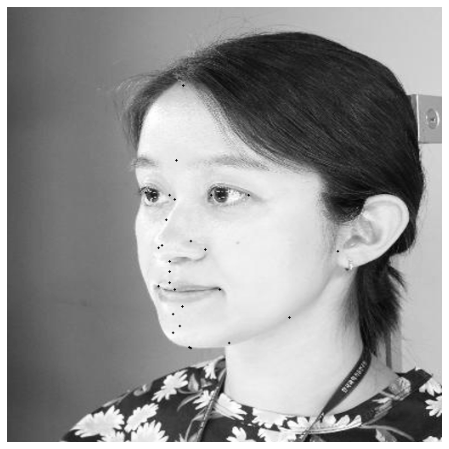

In [5]:
k_dataset_train = kfacedataset(
    image_list=C.IMAGE_LIST,
    label_list=C.LABEL_LIST,
    transform=get_augmentation(data_type="train")
    )

k_dataset_valid = kfacedataset(
    image_list=C.IMAGE_LIST,
    label_list=C.LABEL_LIST,
    transform=get_augmentation(data_type="valid")
    )

# # (Option) visualize dataset
for idx, (image, landmarks) in enumerate(k_dataset_valid): # torch.Size([1, 512, 512])
    if idx == 1:
        vis_keypoints(image, landmarks)

In [6]:
train_dataset, _ = D.random_split(k_dataset_train, [C.LEN_TRAIN_SET, C.LEN_VALID_SET])
_, valid_dataset = D.random_split(k_dataset_valid, [C.LEN_TRAIN_SET, C.LEN_VALID_SET])

train_loader = D.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
valid_loader = D.DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=0)

train_images, train_landmarks = next(iter(train_loader))
valid_images, valid_landmarks = next(iter(valid_loader))

print(f"| Size of image in train_loader : {train_images.shape}")
print(f"| Size of label in train_loader : {train_landmarks.shape}")
print(f"| Size of image in train_loader : {valid_images.shape}")
print(f"| Size of label in train_loader : {valid_landmarks.shape}")

| Size of image in train_loader : torch.Size([64, 1, 512, 512])
| Size of label in train_loader : torch.Size([64, 27, 2])
| Size of image in train_loader : torch.Size([8, 1, 512, 512])
| Size of label in train_loader : torch.Size([8, 27, 2])


In [7]:
from torchvision import models

class resnet18(nn.Module):
    def __init__(self,num_classes=54):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18(pretrained=True)
    
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.model(x)
        
        return x

In [8]:
pretrained_model = '/home/ubuntu/workspace/FLD-scratch/result/face_landmarks_kface.pth'
model = resnet18().cpu()
if pretrained_model:
    state_dict = torch.load(pretrained_model,map_location='cpu')
    model.load_state_dict(state_dict)
model = model.to(device)

RuntimeError: CUDA error: out of memory

In [ ]:
x = torch.randn([1, 1, 512, 512]).to(device)
out = model(x).to(device)
print(f"input : {x.shape} | output : {out.size()}")

In [ ]:
criterion = nn.MSELoss()
optimizer = MADGRAD(params=model.parameters(), lr=C.LEARNING_RATE, weight_decay=C.WEIGHT_DECAY)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=C.EPOCHS, T_mult=1)

In [ ]:
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

loss_min = np.inf

start_time = time.time()
for epoch in range(C.EPOCHS):
    
    model.train()
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    scaler = GradScaler()    
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (images, landmarks) in pbar:

        landmarks = landmarks.view(-1)
        landmarks/=512
        
        images = images.to(device)
        landmarks = landmarks.to(device)
        
        with autocast(enabled=True):
            model = model.to(device)
            
            predictions = model(images)
            prediction = predictions.squeeze()
            loss_train_step = criterion(predictions, landmarks)
        
        scaler.scale(loss_train_step).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
                
        loss_train += loss_train_step
        running_loss = loss_train/(step+1)
        
        description = f"| # Epoch : {epoch + 1} Loss : {(running_loss):.4f}"
        pbar.set_description(description)
        
    with torch.no_grad():
        
        model.eval() 
        
        pbar_valid = tqdm(enumerate(valid_loader), total=len(valid_loader))
        for step, (images, landmarks) in pbar_valid:
                  
            images = images.to(device)
            landmarks = landmarks.view(-1).to(device)
        
            predictions = model(images).to(device)
                    
            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step
            running_loss = loss_valid/(step+1)

            description = f"| # Epoch : {epoch + 1} Loss : {(running_loss):.4f}"
            pbar_valid.set_description(description)
            
            
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(model.state_dict(), '/home/ubuntu/workspace/FLD-scratch/result/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, C.EPOCHS))
        print('Model Saved\n')

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

In [ ]:
start_time = time.time()

with torch.no_grad():

    pretrained_model = '/home/ubuntu/workspace/FLD-scratch/result/face_landmarks_kface.pth'
    model = resnet18().cpu()
    if pretrained_model:
        state_dict = torch.load(pretrained_model,map_location='cpu')
        model.load_state_dict(state_dict)
    best_network = model.to(device)
    
    images, landmarks = next(iter(valid_loader))
    
    images = images.to(device)
    # landmarks *= 512 #* torch.tensor((512,512))    

    predictions = best_network(images).cpu()
    predictions = predictions.view([-1,27,2])
    # predictions *= 512# * torch.tensor((512,512))    
    
    plt.figure(figsize=(10,20))
    
    for img_num in range(2):
        print(images[img_num].shape)
        plt.subplot(2,1,img_num+1)
        plt.imshow(images[img_num].cpu().permute(1,2,0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num].T[0], predictions[img_num].T[1], c = 'r', s = 5)
        plt.scatter(landmarks[img_num].T[0], landmarks[img_num].T[1], c = 'g', s = 5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 